Ce projet a pour but de classifier des phrases. Par exemple à partir de commentaires de réseaux sociaux concernant un film, le modèle doit prédire si leurs avis est positif ou non négatif. Pour faire cela on va coder un RNN (Recurrent Neural Network), on passera en entrée de ce réseau de neurones des phrases sous formes de vecteurs binaires.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [87]:
data= {
    'Phrase' : ['Bon film', "Bof je m'attendais à mieux", "Excellent film",
               'Ce film est trop nul', "Wow j'ai adoré", "Nul",
               "J'ai vraiment détesté ce film", "Très bon film", 'Bon film' "Film nul",
               'Bon film'],
    'Appréciation' : ['Aimé', 'Pas aimé', "Aimé", 'Pas aimé', 'Aimé', 'Pas aimé',
                     'Pas aimé', 'Aimé', 'Aimé', 'Pas aimé','Aimé']
}

In [79]:
df= pd.DataFrame(data)

In [52]:
df

,Phrase,Appréciation
0,Bon film,Aimé
1,Bof je m'attendais à mieux,Pas aimé
2,Excellent film,Aimé
3,Ce film est trop nul,Pas Aimé


In [80]:
df_tilde= df
df_tilde["Appréciation"]=df_tilde["Appréciation"].replace({'Aimé':1, 'Pas aimé': 0})

In [81]:
df_tilde

,Phrase,Appréciation
0,Bon film,1
1,Bof je m'attendais à mieux,0
2,Excellent film,1
3,Ce film est trop nul,0
4,Wow j'ai adoré,1
5,Nul,0
6,J'ai vraiment détesté ce film,0
7,Très bon film,1
8,Bon film,1


In [7]:
df.dtypes

Phrase          object
Appréciation     int64
dtype: object

In [92]:
def softmax(liste):
    
    list_exp=[]
    list_final=[]
    for i in range(len(liste)):
        list_exp.append(np.exp(liste[i]))
        
    for j in range(len(liste)):
        list_final.append(np.exp(liste[j])/np.sum(list_exp))
        
    return list_final

In [93]:
L=np.array([1,2,3])
L=L.reshape((3,1))
softmax(L)

[array([0.09003057]), array([0.24472847]), array([0.66524096])]

In [9]:
L=[1,2,3]

In [10]:
softmax(L)

[0.09003057317038046, 0.24472847105479767, 0.6652409557748219]

In [11]:
def suppr_doublons(liste):
    
    unique=[]
    for i in range(len(liste)):
        if liste[i] not in unique:
            unique.append(liste[i])
    return unique

In [12]:
def Extract_word(phrase):
    
    Word=[]
    mot=''
    j=0
    while(j<len(phrase)):
        while(j<len(phrase) and phrase[j]!= ' '):
            mot= mot+phrase[j]
            j=j+1
            
        if (mot != ''):
            Word.append(mot)
            
        mot=''
        j=j+1
        
    return Word 
        

In [13]:
def Vocabulaire(data):
    
    Voc=[]
    for i in range(data.shape[0]):
        
        word_list= Extract_word(data['Phrase'][i])
        Voc= Voc+word_list
        
    Voc= suppr_doublons(Voc)
            
    return Voc
        
    

In [14]:
Vocabulaire(df)

['Bon', 'film', 'Bof', 'je', "m'attendais", 'à', 'mieux']

In [15]:
def Vectorize_word(Vocabulaire, word):
    
    binaire=[]
    for e in Vocabulaire:
        if (e==word):
            binaire.append(1)
        else:
            binaire.append(0)
            
    return np.array(binaire)

In [16]:
Vectorize_word(Vocabulaire(df), 'film').shape

(7,)

In [17]:
Vectorize_word(Vocabulaire(df), 'mieux')

array([0, 0, 0, 0, 0, 0, 1])

In [18]:
def initialisation(data, nbr_classe):
    
    dimension_vocab= len(Vocabulaire(data))
    parametre= {
        "a_0": np.random.randn(dimension_vocab,1),
        "Wya": np.random.randn(nbr_classe, dimension_vocab),
        "Waa": np.random.randn(dimension_vocab, dimension_vocab),
        "Wax": np.random.randn(dimension_vocab, dimension_vocab),
        "by":  np.random.randn(1, 1),
        "ba":  np.random.randn(1, 1)
        
    }
    
    return parametre

In [19]:
def forward(data,parametre,f):
    
    parametre_a_T=[]
    O=[]
    
    for j in range(data.shape[0]):
        
        
        r= len(Vocabulaire(data))
        T= len(Extract_word(data['Phrase'][j]))
        word= Extract_word(data['Phrase'][j])
        dictio={}
        parametre_a_T.append(dictio)
        parametre_a_T[j]= {'a_0': parametre['a_0']}
        X_word={}
        for i in range(1,T+1):
            X_word['X_'+ str(i)]= Vectorize_word(Vocabulaire(data),word[i-1]).reshape((r,1))
            parametre_a_T[j]["a_"+str(i)]= f(np.dot(parametre['Wax'], X_word['X_'+str(i)]) + np.dot(parametre['Waa'], parametre_a_T[j]['a_'+str(i-1)]) + parametre['ba'])
            
        Z= np.dot(parametre['Wya'], parametre_a_T[j]["a_"+str(T)]) + parametre['by']
        O.append(softmax(Z))
        
    return O, parametre_a_T
        
            

In [20]:
def f_tanh(liste):
    
    liste_tanh=[]
    for j in range(len(liste)):
        liste_tanh.append(np.tanh(liste[j]))
        
    return (np.array(liste_tanh)).reshape((len(liste),1))

In [21]:
L=np.array([1,3,3]).reshape((3,1))

In [22]:
f_tanh(L)

array([[0.76159416],
       [0.99505475],
       [0.99505475]])

In [23]:
def y_individu(valeur, nbr_classe):
    
    y=[]
    L=[]
    for i in range(nbr_classe):
        L.append(i)
        
    for i in range(nbr_classe):
        if(valeur==L[i]):
            y.append(1)
            
        else:
            y.append(0)
        
    return np.array(y)
    

In [24]:
y_individu(2,3)

array([0, 0, 1])

In [25]:
parametre= initialisation(df,2)

In [26]:
g= lambda x: y_individu(x,2)
valeur= df["Appréciation"].apply(g)

In [27]:
valeur[0]

array([0, 1])

In [28]:
y=valeur[0].reshape((2,1))

In [29]:
y

array([[0],
       [1]])

In [94]:
O,A=forward(df, parametre, f_tanh)

In [95]:
O[0]
#vecteur= [element[0] for element in O[0]]
#np.array(vecteur)

[array([0.00258568]), array([0.99741432])]

In [32]:
A[0]['a_1'].T

array([[ 0.13710325, -0.99364524,  0.96162084,  0.99944252,  0.99990756,
         0.99998051,  0.98285054]])

In [33]:
def loss_function(data, nbr_classe, O):
    
    somme=0
    g= lambda x: y_individu(x,nbr_classe)
    valeur= data["Appréciation"].apply(g)
    for j in range(data.shape[0]):
        y= valeur[j].reshape((nbr_classe,1))
        somme= somme+ np.sum(np.log(O[j])-y)
        
    return somme
        

In [34]:
def Jac_f(liste): #Jacobien de la fonction de tanh
    
    matrix= np.eye(len(liste))
    for i in range(len(liste)):
        matrix[i][i]= 1-(np.tanh(liste[i]))**2
        
    return matrix

In [218]:
L=[1,2,3]

In [219]:
Jac_f(L)

array([[0.41997434, 0.        , 0.        ],
       [0.        , 0.07065082, 0.        ],
       [0.        , 0.        , 0.00986604]])

In [35]:
def backward_propagation(data, f, parametre, nbr_classe):
    
    gradients={}
    r= len(Vocabulaire(data))
    
    #Way
    grad_Way=np.zeros((nbr_classe,r))
    
    #Wax
    grad_Wax=np.zeros((r,r))
    
    #Waa
    grad_Waa= np.zeros((r,r))
    
    #ba
    grad_ba=np.zeros((1,1))
    
    #by
    grad_by=np.zeros((1,1))
    
    
    
    g= lambda x: y_individu(x,nbr_classe)
    valeur= data["Appréciation"].apply(g)
    for j in range(data.shape[0]):
        y= valeur[j].reshape((nbr_classe,1))
        O,A= forward(data, parametre, f)
        
        
        O[j]= [element[0] for element in O[j]]
        O[j]= np.array(O[j])
        O[j]=O[j].reshape((nbr_classe,1))
        
        
        
        
        T= len(Extract_word(data['Phrase'][j]))
        
        #gradient Way
        grad_Way= grad_Way+ np.dot(O[j]-y, (A[j]['a_'+str(T)]).T)
        
        #gradient Wax
        
        L=[]
        matrix= np.dot(parametre['Wya'], Jac_f(A[j]['a_'+str(T)]))
        L.append(matrix)
        e=T-1
        while(e>=1):
            matrix= np.dot(matrix, np.dot(parametre['Waa'], Jac_f(A[j]['a_'+str(e)])))
            L.append(matrix)
            e=e-1
        
        word= Extract_word(data['Phrase'][j])
        X_word={}
        
        for i in range(1,T+1):
            X_word['X_'+ str(i)]= Vectorize_word(Vocabulaire(data),word[i-1]).reshape((r,1))
        
        
        L=L[::-1]
        e=1
        somme= np.zeros((r,r))
        while(e<=T):
            somme= somme+ np.dot(np.dot(L[e-1].T, O[j]-y), (X_word['X_'+str(e)]).T)
            e=e+1
            
        grad_Wax= grad_Wax+somme
        
        
        #gradient Waa
    

        e=1
        somme= np.zeros((r,r))
        while(e<=T):
            somme= somme+ np.dot(np.dot(L[e-1].T, O[j]-y), (A[j]['a_'+str(e-1)]).T)
            e=e+1
            
        grad_Waa= grad_Waa + somme
        
        

        #gradient ba 
        
        e=1
        somme= 0
        while(e<=T):
            somme= somme+ np.dot((np.dot(L[e-1].T, O[j]-y)).T, np.ones(r).reshape((r,1)))
            e=e+1
            
        grad_ba= grad_ba + somme
     
    
       #gradient by
        
        grad_by= grad_by+ np.dot((O[j]-y).T, np.ones(nbr_classe).reshape((nbr_classe,1)))
        
        
    gradients['Wya']= grad_Way
    gradients['Wax']= grad_Wax
    gradients['Waa']= grad_Waa
    gradients['ba']= grad_ba
    gradients['by']= grad_by
        
        
    return gradients
    
        
        
        
        
        

In [36]:
def update(parametre, gradients, learning_rate):
    
    parametre['Wya']= parametre['Wya']-learning_rate*gradients['Wya']
    parametre['Wax']= parametre['Wax']-learning_rate*gradients['Wax']
    parametre['Waa']= parametre['Waa']-learning_rate*gradients['Waa']
    parametre['ba']= parametre['ba']-learning_rate*gradients['ba']
    parametre['by']= parametre['by']-learning_rate*gradients['by']
    
    
    return parametre

In [422]:
parametre= initialisation(df, 2)

In [510]:
gradients= backward_propagation(df, f_tanh, parametre, 2)

In [498]:
gradients['ba'].shape

(1, 1)

In [494]:
L[0].shape

(2, 7)

In [462]:
np.dot((O-y),A[0]['a_1'].T).shape

(2, 7)

In [37]:
def RNN(data, learning_rate, nbr_iter, nbr_classe, f):
    
    #Liste pour les valeur de la fonction loss
    
    Loss=[]
    acc=[]
    parametre= initialisation(data, nbr_classe)
    
    for e in tqdm(range(nbr_iter)):
        
        prediction=[]
    
    
        #Forward
    
        O,A= forward(data, parametre, f)
        for j in range(data.shape[0]):
            O[j]= [element[0] for element in O[j]]
            O[j]= np.array(O[j])
            O[j].reshape((nbr_classe,1))
            
        for j in range(data.shape[0]):
           
             indice= predict(O[j])
             prediction.append(indice)
                
                
        accuracy= sum(prediction==data["Appréciation"])/(data.shape[0])
        acc.append(accuracy)
        
        L= loss_function(data, nbr_classe, O)
        Loss.append(L)
        
        
        #Backward
        
        gradients= backward_propagation(data, f, parametre, nbr_classe)
        parametre= update(parametre, gradients, learning_rate)
        
    
  
        
    
        
        
    #Graphique
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(Loss, label="Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(acc, label="accuracy")
    plt.legend()
    plt.show()
   
    
    
    return parametre
        
        
    
    

In [38]:
def predict(O):
    
    indice_max= np.argmax(O)
    return indice_max
    

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.58it/s]


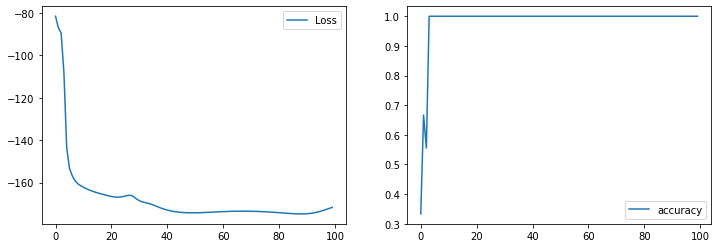

In [90]:
parametre= RNN(df_tilde, 0.01, 100, 2, f_tanh)

In [91]:
parametre

{'a_0': array([[ 1.18308151],
        [-0.75520398],
        [-0.1327739 ],
        [-1.54197931],
        [ 0.53715351],
        [-1.21791163],
        [ 1.59020118],
        [-1.10626274],
        [ 1.0380062 ],
        [-0.29473374],
        [-0.07591486],
        [-0.51564325],
        [ 1.07558908],
        [-1.53418802],
        [ 1.97039617],
        [ 0.71278035],
        [ 1.00696731],
        [-1.04689416],
        [ 0.51026412],
        [-1.09728072],
        [ 0.11944533],
        [ 0.7973733 ]]),
 'Wya': array([[ 0.37325115, -1.62548057, -0.09670176,  0.62301552, -0.05036148,
          1.02111656,  0.395541  ,  0.4460131 , -1.30520027,  0.08497379,
          1.02323584, -0.66118211, -0.59679745, -1.65009153,  0.39369341,
          0.45078373, -0.47120756, -0.05285778, -1.05223094, -1.5949106 ,
         -1.21629668,  1.65920069],
        [ 0.10322629, -1.45645602, -1.16187685, -2.56447311, -0.62625774,
         -1.71299754,  0.97180358,  1.4720347 , -0.89020471, -0.84945324